In [1]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')
# wv = api.load("fasttext-wiki-news-subwords-300")

In [2]:
with open("./top1000_nouns.txt", "r") as f:
    all_words = f.read().splitlines()

In [3]:
import numpy as np
from annoy import AnnoyIndex
from itertools import combinations

# --- Step 1 is the same: Generate pairs and direction vectors ---
word_pairs = list(combinations(all_words, 2))
valid_pairs = []
direction_vectors = []
for w1, w2 in word_pairs:
    try:
        direction = wv[w1] - wv[w2]
        # Normalize the vector for cosine similarity search
        norm = np.linalg.norm(direction)
        if norm > 0:
            valid_pairs.append((w1, w2))
            direction_vectors.append(
                {
                    "pair": (w1, w2),
                    "vector": direction / norm
                }
            )
            
    except KeyError:
        continue



In [4]:
import pickle
# Save the direction vectors to a file
with open("direction_vectors.pkl", "wb") as f:
    pickle.dump(direction_vectors, f)

In [1]:
import pickle

with open("direction_vectors.pkl", "rb") as f:
    direction_vectors = pickle.load(f)

In [2]:
len(direction_vectors)

486590

In [3]:
from sklearn.cluster import HDBSCAN
from tqdm import tqdm
import numpy as np
import faiss

In [4]:
# do pca
from sklearn.decomposition import PCA, IncrementalPCA
batch_size = 10000
pca = IncrementalPCA(n_components=64, batch_size=batch_size)
for i in tqdm(range(0, len(direction_vectors), batch_size)):
    batch = direction_vectors[i:i+batch_size]
    vectors = np.array([dv["vector"] for dv in batch])
    pca.partial_fit(vectors)
X = np.array([dv["vector"] for dv in direction_vectors])
X_reduced = pca.transform(X)

100%|██████████| 49/49 [00:11<00:00,  4.35it/s]


In [5]:
from scipy.sparse import csr_matrix

In [6]:
num_vectors = len(X_reduced)


In [ ]:
# print("Step 2: Building the Faiss Index (IndexIVFPQ)...")
# # Number of clusters/partitions for the inverted file. A common heuristic is 4*sqrt(N).
# nlist = int(4 * np.sqrt(num_vectors))
# # Number of sub-quantizers for Product Quantization
# m = 8  
# # Number of bits per sub-quantizer
# bits = 8

# # a. Define the coarse quantizer (for partitioning) and the final index
# quantizer = faiss.IndexFlatL2(64)  # The coarse quantizer
# index = faiss.IndexIVFPQ(quantizer, 64, nlist, m, bits)

# # b. Train the index on the data
# print("Training the index...")
# # start_time = time.time()
# index.train(X_reduced)
# # end_time = time.time()
# # print(f"Training took {end_time - start_time:.2f} seconds.")

# index.add(X_reduced)

# # --- 3. Create a K-Neighbors Graph (Corrected) ---
# print("Step 3: Finding k-nearest neighbors using Faiss...")
# k_neighbors = 128 

# # Search for the k+1 neighbors because the first result for each point is itself.
# distances, indices = index.search(X_reduced, k_neighbors + 1)

# # a. Build the sparse distance matrix for HDBSCAN (with filtering)
# print("Constructing the sparse distance matrix...")

# # We are interested in neighbors, so we slice off the first column (the point itself)
# neighbor_indices = indices[:, 1:]
# neighbor_distances = distances[:, 1:]

# # Create a boolean mask to identify valid neighbors (index != -1)
# valid_mask = neighbor_indices != -1

# # Get the row indices for each valid neighbor
# # np.arange creates [0, 1, 2, ...], reshape makes it a column vector,
# # and broadcasting expands it to match the shape of neighbor_indices.
# rows_template = np.arange(num_vectors).reshape(-1, 1)
# broadcasted_rows = np.broadcast_to(rows_template, neighbor_indices.shape)

# # Apply the mask to get only the valid rows, columns, and data
# rows = broadcasted_rows[valid_mask]
# cols = neighbor_indices[valid_mask]
# data = neighbor_distances[valid_mask]

# # The csr_matrix is a memory-efficient way to store this graph
# sparse_distance_matrix = csr_matrix((data, (rows, cols)), shape=(num_vectors, num_vectors))

# print("Sparse matrix constructed successfully")

: 

In [ ]:
import numpy as np
from annoy import AnnoyIndex
from scipy.sparse import csr_matrix
import time

# --- Prepare Data ---
print("Step 1: Generating sample data...")
num_vectors = len(direction_vectors)
embedding_dim = 64
print("-" * 30)

# --- 1. Build the Annoy Index ---
print("Step 2: Building the Annoy Index...")

# a. Initialize the index
# 'angular' is cosine distance, which is great for word embeddings.
# 'euclidean' is another common choice.
f = embedding_dim
annoy_index = AnnoyIndex(f, 'angular')

# b. Add all items to the index in a loop
for i, vec in enumerate(X_reduced):
    annoy_index.add_item(i, vec)

# c. Build the index
# n_trees affects the accuracy/speed trade-off. More trees are more accurate
# but result in a larger index and longer build time.
start_time = time.time()
annoy_index.build(n_trees=50) 
end_time = time.time()

print(f"Building index took {end_time - start_time:.2f} seconds.")
print("-" * 30)


# --- 2. Find Neighbors and Prepare Sparse Matrix Data ---
# We loop through every item in the index to find its k-nearest neighbors.
print("Step 3: Finding neighbors and preparing sparse matrix data...")
k_neighbors = 128

rows = []
cols = []
data = []

start_time = time.time()
for i in range(num_vectors):
    # Find k+1 neighbors (the first result is always the item itself)
    # The 'include_distances=True' is crucial.
    neighbors, distances = annoy_index.get_nns_by_item(
        i, k_neighbors + 1, include_distances=True
    )

    # For each point, add its neighbors (excluding itself) to our lists
    for j in range(1, k_neighbors + 1):
        rows.append(i)
        cols.append(neighbors[j])
        data.append(distances[j])
end_time = time.time()
print(f"Neighbor search took {end_time - start_time:.2f} seconds.")
print("-" * 30)


# --- 3. Construct the CSR Matrix ---
# Create the final sparse matrix from the collected data.
print("Step 4: Constructing the final sparse distance matrix...")
sparse_distance_matrix = csr_matrix((data, (rows, cols)), shape=(num_vectors, num_vectors))

print("Sparse distance matrix created successfully.")
print(f"Shape: {sparse_distance_matrix.shape}")
print(f"Number of stored elements: {sparse_distance_matrix.nnz}")

# This `sparse_distance_matrix` can now be fed directly into HDBSCAN
# with metric='precomputed', exactly as in the previous examples.

Step 1: Generating sample data...
------------------------------
Step 2: Building the Annoy Index...
Building index took 8.74 seconds.
------------------------------
Step 3: Finding neighbors and preparing sparse matrix data...


In [ ]:
import hdbscan
print("Step 4: Running HDBSCAN with the precomputed distance matrix...")
clusterer = hdbscan.HDBSCAN(
    metric='precomputed',
    min_cluster_size=15,
    min_samples=5,
    # Other HDBSCAN params can be set here
)

cluster_labels = clusterer.fit_predict(sparse_distance_matrix)

# --- Results ---
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = np.sum(cluster_labels == -1)

print("-" * 30)
print(f"Clustering complete.")
print(f"Number of clusters found: {n_clusters}")
print(f"Number of noise points: {n_noise}")

Step 4: Running HDBSCAN with the precomputed distance matrix...


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


: 

In [ ]:
from sklearn.cluster import Birch
clusterer = Birch(threshold=0.5, n_clusters=None)
cluster_labels = clusterer.fit_predict(X)

In [6]:
nb_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print(f"Number of clusters: {nb_clusters}")

Number of clusters: 18849


In [7]:
# # print clusters
# for cluster_id in list(cluster_labels)[:10]:
#     if cluster_id == -1:
#         continue  # Skip noise points
#     cluster_indices = np.where(cluster_labels == cluster_id)[0]
#     cluster_pairs = [direction_vectors[i]["pair"] for i in cluster_indices]
#     print(f"Cluster {cluster_id}: {len(cluster_pairs)} pairs")
#     for pair in cluster_pairs:
#         print(f"  {pair[0]} - {pair[1]}")
#     print()

In [10]:
# filter cluster with unique pairs
new_clusters = {}
for cluster_id in tqdm(set(cluster_labels)):
    if cluster_id == -1:
        continue  # Skip noise points
    cluster_indices = np.where(cluster_labels == cluster_id)[0]
    cluster_pairs = [direction_vectors[i]["pair"] for i in cluster_indices]
    
    seen_words = set()
    unique_pairs = []
    for w1, w2 in cluster_pairs:
        if w1 not in seen_words and w2 not in seen_words:
            unique_pairs.append((w1, w2))
            seen_words.add(w1)
            seen_words.add(w2)
    new_clusters[cluster_id] = unique_pairs
    

100%|██████████| 18849/18849 [00:04<00:00, 4647.66it/s]


In [17]:
min_cluster_size = 5
filtered_clusters = {k: v for k, v in new_clusters.items() if len(v) >= min_cluster_size}
print(f"Number of filtered clusters: {len(filtered_clusters)}")

Number of filtered clusters: 1296


In [19]:
filtered_clusters.keys()

dict_keys([14, 16, 28, 41, 63, 67, 83, 86, 94, 125, 152, 154, 155, 165, 231, 261, 312, 366, 371, 391, 404, 475, 551, 558, 560, 566, 567, 570, 581, 583, 591, 604, 608, 624, 631, 634, 635, 640, 663, 720, 792, 818, 825, 857, 864, 878, 946, 954, 955, 957, 958, 1019, 1065, 1222, 1223, 1249, 1288, 1298, 1307, 1316, 1348, 1382, 1402, 1403, 1406, 1417, 1454, 1455, 1464, 1467, 1484, 1485, 1501, 1502, 1503, 1505, 1506, 1507, 1508, 1510, 1511, 1515, 1516, 1517, 1518, 1519, 1522, 1525, 1526, 1539, 1540, 1548, 1554, 1555, 1590, 1603, 1614, 1643, 1644, 1717, 1838, 1859, 1896, 1902, 1904, 1905, 1924, 1963, 1966, 2021, 2070, 2075, 2131, 2172, 2173, 2184, 2202, 2220, 2233, 2234, 2235, 2238, 2242, 2244, 2245, 2276, 2277, 2278, 2322, 2323, 2324, 2326, 2327, 2328, 2329, 2331, 2332, 2333, 2334, 2335, 2336, 2345, 2346, 2347, 2349, 2350, 2351, 2356, 2357, 2358, 2363, 2370, 2371, 2372, 2382, 2385, 2389, 2398, 2399, 2402, 2418, 2420, 2422, 2424, 2425, 2427, 2429, 2430, 2431, 2433, 2435, 2438, 2439, 2446, 2467,

In [21]:
# find the cluster with "boy" in it
target_word = "boy"
target_cluster = None
for cluster_id, pairs in filtered_clusters.items():
    if any(target_word in pair for pair in pairs):
        target_cluster = cluster_id
        break
if target_cluster is not None:
    print(f"Cluster containing '{target_word}': {target_cluster}")
    print(f"Pairs in this cluster: {filtered_clusters[target_cluster]}")

Cluster containing 'boy': 1464
Pairs in this cluster: [('time', 'man'), ('way', 'woman'), ('part', 'girl'), ('course', 'boy'), ('relationship', 'daughter')]


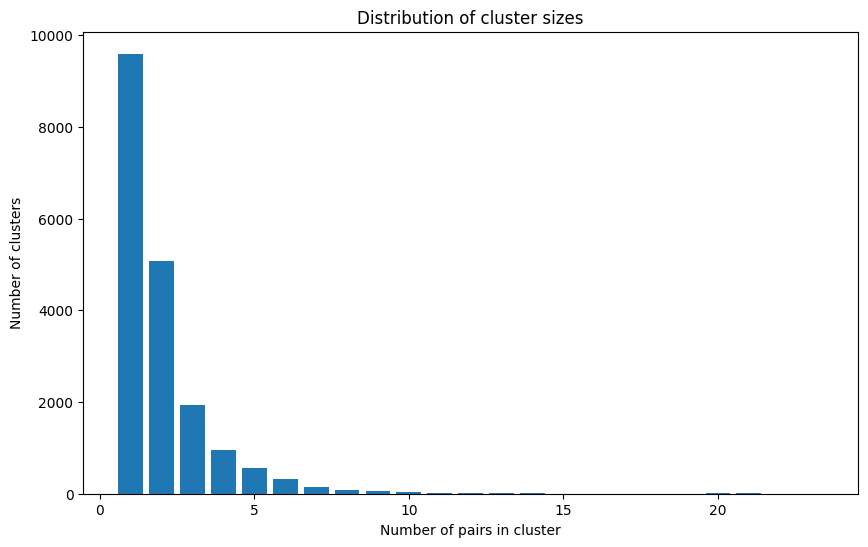

In [16]:
# plot nb elem per cluster
import matplotlib.pyplot as plt
cluster_sizes = [len(pairs) for pairs in new_clusters.values()]
max_size = max(cluster_sizes)
plt.figure(figsize=(10, 6))
# histogram
plt.hist(cluster_sizes, bins=range(1, max_size + 2), align='left', rwidth=0.8)
plt.xlabel('Number of pairs in cluster')
plt.ylabel('Number of clusters')
plt.title('Distribution of cluster sizes')  
plt.show()